### RankForecasting-shortterm-paper
basedon :stint-test-strategy-shortterm
    
+ comparing models: naive, deepar, oracle, pitmodel

In [36]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import mxnet as mx
from mxnet import gluon
import pickle
import json
import random
import inspect
from scipy import stats
from sklearn.metrics import mean_squared_error
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from indycar.model.ZeroPredictor import ZeroPredictor
from pandas.plotting import register_matplotlib_converters
from gluonts.model.forecast import SampleForecast
register_matplotlib_converters()

#from indycar.model.stint_predictor_fastrun import *
import indycar.model.stint_simulator_shortterm_pitmodel as stint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def simulation(datasetid, testevent, taskid, runts, expid, predictionlen, 
               datamode, loopcnt, featuremode = stint.FEATURE_STATUS,
              pitmodel = 0, model = 'oracle'):
    #
    # configurataion
    #
    # model path:  <_dataset_id>/<_task_id>-<trainid>/
    #_dataset_id = 'indy2013-2018-nocarid'
    stint.init(pitmodel)
    stint._dataset_id = datasetid
    stint._test_event = testevent
    #_test_event = 'Indy500-2019'

    stint._feature_mode = featuremode
    stint._context_ratio = 0.

    stint._task_id = taskid  # rank,laptime, the trained model's task
    stint._run_ts = runts   #COL_LAPTIME,COL_RANK
    stint._exp_id=expid  #rank, laptime, laptim2rank, timediff2rank... 

    stint._train_len = 40
    predictor = stint.load_model(predictionlen, model,trainid='2018')

    ret2 = {}
    for i in range(loopcnt):
        #df, full_samples, full_tss
        ret2[i] = stint.run_simulation_shortterm(predictor, predictionlen, stint.freq, datamode=datamode)

    acc = []
    for i in ret2.keys():
        df = ret2[i][0]
        _x = stint.get_evalret_shortterm(df)
        acc.append(_x)

    b = np.array(acc)
    print(np.mean(b, axis=0))
    
    #save keys
    #stint._pitmodel.save_keys('pitmodel-keys.pickle')
    
    return b, ret2

In [24]:
def test_pitmodel(modelfile, testevent, runts, loopcnt=10, model='oracle'):
    #pitmodel-m60-mlp-e500-l10-10-5-student-d0.1.pickle
    if runts == 'RANK':
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                    'rank',stint.COL_RANK,'rank',
                   2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                      pitmodel=modelfile, model=model)        
    else:
        acc, ret = simulation('indy2013-2018-nocarid-context40', testevent, 
                        'timediff',stint.COL_TIMEDIFF,'timediff2rank',
                       2, stint.MODE_ORACLE_LAPONLY,loopcnt, 
                          pitmodel=modelfile, model=model)

    #print(np.mean(acc, axis=0))
    return acc, ret

In [76]:
def plot_prob_forecasts_ex(ts_entry, forecast_entry, ts2, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        
        ts2.iloc[-plot_length:,0].plot(ax=axs, linewidth=1, label='CurRank')  # plot the time series
        
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.ylabel('Rank position')
        plt.xlabel('Lap')
        
        laps = range(1, 200, 20)
        
        #axs.set_xticks(laps)
        #axs.set_xticklabels([1+x*30 for x in range(7)])
        #axs.set_xticklabels(laps)
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

### test low mode

In [26]:
acc, ret = {}, {}

In [27]:
mid = 'oracle-2018'
acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1)
_ = prisk(ret[mid][0][1], ret[mid][0][2])
mid = 'oracle-2019'
acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-2019', 'TIMEDIFF', loopcnt=1)
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.85}, mae={0.85}, rmse={1.97},r2={0.95}, 
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
[[0.85106383 0.85018727 1.97465211 0.94556006]
 [0.71808511 1.33932584 3.24896987 0.85262365]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset with 7 races, 58 cars
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
model: acc={0.81}, mae={0.78}, rmse={1.92},r2={0.95}, 
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
[[0.80851064 0.7848641  1.92394012 0.95165846]
 [0.73404255 1.16255107 3.05012312 0.87850116]]


In [28]:
mid = 'deepar-2018'
acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-2018', 'TIMEDIFF', loopcnt=1, model='deepAR')
_ = prisk(ret[mid][0][1], ret[mid][0][2])
mid = 'deepar-2019'
acc[mid], ret[mid] = test_pitmodel('oracle', 'Indy500-2019', 'TIMEDIFF', loopcnt=1, model='deepAR')
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset with 7 races, 58 cars
predicting model=deepAR, plen=2
loading model...done!, ctx:gpu(0)
model: acc={0.70}, mae={2.02}, rmse={3.64},r2={0.82}, 
            naive: acc={0.72}, mae={1.34}, rmse={3.25},r2={0.85}
[[0.70212766 2.01535581 3.63704411 0.81531417]
 [0.71808511 1.33932584 3.24896987 0.85262365]]


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset with 7 races, 58 cars
predicting model=deepAR, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4
model: acc={0.64}, mae={1.68}, rmse={3.43},r2={0.85}, 
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
[[0.63829787 1.68449103 3.43091605 0.84627037]
 [0.73404255 1.16255107 3.05012312 0.87850116]]


In [ ]:
test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'RANK')
test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2019', 'RANK')

In [ ]:
test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2018', 'TIMEDIFF')
test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2019', 'TIMEDIFF')

#### =====================================================

In [45]:
def prisk(full_samples, full_tss, verbose = False):
    carlist = full_tss.keys()
    tss = []
    forecasts = []
    forecasts_mean = []
    freq = '1min'
    start = pd.Timestamp("01-01-2019", freq=freq) 

    for car in carlist:
        testcar = car
        fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)

        samples = np.mean(full_samples[testcar][:, 12:], axis =0, keepdims=True)
        fc_mean = SampleForecast(samples = samples, freq=freq, start_date=start + 12)

        index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
        ts = pd.DataFrame(index = index, data = full_tss[testcar])    

        tss.append(ts)
        forecasts.append(fc)
        forecasts_mean.append(fc_mean)

    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))
    if verbose:
        print(json.dumps(agg_metrics, indent=4))  
    
    print(agg_metrics["wQuantileLoss[0.1]"], agg_metrics["wQuantileLoss[0.5]"],agg_metrics["wQuantileLoss[0.9]"])
    
    return agg_metrics

In [49]:
mid = 'oracle-2019'
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  
Running evaluation: 100%|██████████| 32/32 [00:00<00:00, 145.95it/s]

0.035213211672590915 0.05695823714072826 0.03166110887170654


In [48]:
mid = 'deepar-2019'
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  
Running evaluation: 100%|██████████| 32/32 [00:00<00:00, 139.08it/s]

0.0688995565978966 0.12081791197918575 0.07481402763018065


In [51]:
mid = 'pitmodel-2019'
acc[mid], ret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2019', 'RANK',loopcnt=1)
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0
INFO:root:Using GPU


init: load dataset with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=oracle, plen=2
loading model...done!, ctx:gpu(0)
a short ts: carid=88，len=4


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  
Running evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

model: acc={0.74}, mae={1.19}, rmse={3.01},r2={0.88}, 
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
[[0.7393617  1.19097531 3.01220352 0.88150336]
 [0.73404255 1.16255107 3.05012312 0.87850116]]


Running evaluation: 100%|██████████| 32/32 [00:00<00:00, 151.39it/s]

0.05253643104059023 0.07893290336765729 0.05781328251920798


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  
Running evaluation: 100%|██████████| 33/33 [00:00<00:00, 155.62it/s]

{
    "MSE": 8.402248300124706,
    "abs_error": 6920.0,
    "abs_target_sum": 74024.0,
    "abs_target_mean": 14.542421627584766,
    "seasonal_error": 0.12121212121212122,
    "MASE": 7.182848613920068,
    "sMAPE": 0.14089533859055473,
    "MSIS": 160.82658843740634,
    "QuantileLoss[0.1]": 4435.0,
    "Coverage[0.1]": 0.1452067226679177,
    "QuantileLoss[0.5]": 6920.0,
    "Coverage[0.5]": 0.2730813896346143,
    "QuantileLoss[0.9]": 4723.0,
    "Coverage[0.9]": 0.4481398219861627,
    "RMSE": 2.8986631919084194,
    "NRMSE": 0.19932465624639129,
    "ND": 0.09348319463957636,
    "wQuantileLoss[0.1]": 0.05991300118880363,
    "wQuantileLoss[0.5]": 0.09348319463957636,
    "wQuantileLoss[0.9]": 0.0638036312547282,
    "mean_wQuantileLoss": 0.07239994236103607,
    "MAE_Coverage": 0.24132850368238024
}
0.05991300118880363 0.09348319463957636 0.0638036312547282


In [50]:
mid = 'currank-2019'
acc[mid], ret[mid] = test_pitmodel('pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle', 'Indy500-2019', 'RANK',loopcnt=1,model='naive')
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset with 7 races, 58 cars
init model:pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle
init pitmodel as PitModelMLP(pitmodel)
predicting model=naive, plen=2
a short ts: carid=88，len=4


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  
Running evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

model: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}, 
            naive: acc={0.73}, mae={1.16}, rmse={3.05},r2={0.88}
[[0.73404255 1.16255107 3.05012312 0.87850116]
 [0.73404255 1.16255107 3.05012312 0.87850116]]


Running evaluation: 100%|██████████| 32/32 [00:00<00:00, 154.96it/s]

0.07993452795387641 0.07993452795387641 0.07993452795387641


In [74]:
_ = prisk(ret[mid][0][1], ret[mid][0][2])

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  # This is added back by InteractiveShellApp.init_path()
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  
Running evaluation: 100%|██████████| 33/33 [00:00<00:00, 141.39it/s]

0.05991300118880363 0.09348319463957636 0.0638036312547282


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


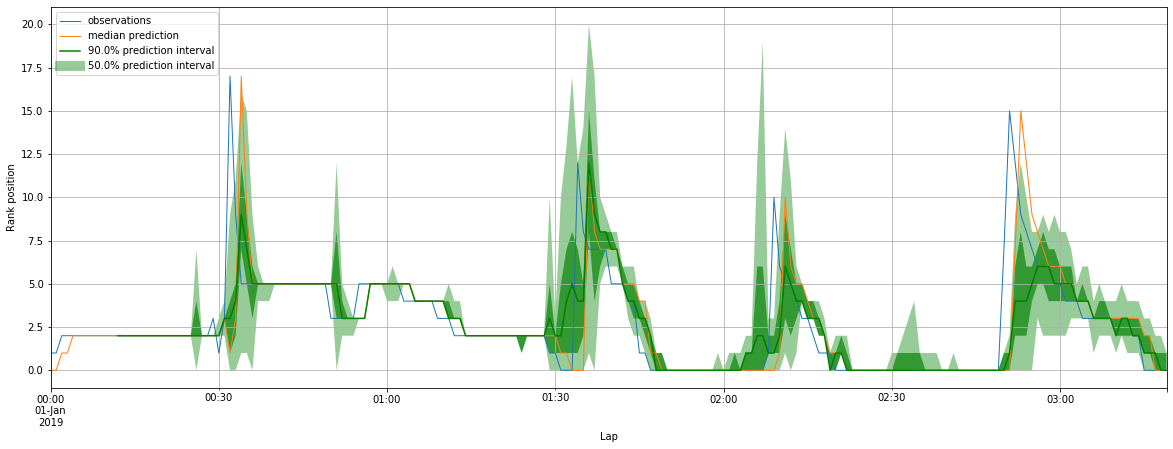

In [77]:
mid = 'pitmodel-2018'
full_samples,full_tss = ret[mid][0][1], ret[mid][0][2]
testcar = 12
freq = '1min'
start = pd.Timestamp("01-01-2019", freq=freq) 
fc = SampleForecast(samples = full_samples[testcar][:, 12:], freq=freq, start_date=start + 12)
index = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))
ts = pd.DataFrame(index = index, data = full_tss[testcar])

tss2 = np.zeros_like(full_tss[testcar])
tss2[2:] = full_tss[testcar][:-2]
index2 = pd.date_range(start='2019-01-01 00:00:00', freq = 'T', periods = len(full_tss[testcar]))

ts2 = pd.DataFrame(index = index2, data = tss2)

plot_prob_forecasts_ex([ts], [fc], ts2,'output-car12')

In [72]:
%debug

> /scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/pandas/core/indexing.py(233)_has_valid_tuple()
    231         for i, k in enumerate(key):
    232             if i >= self.obj.ndim:
--> 233                 raise IndexingError("Too many indexers")
    234             try:
    235                 self._validate_key(k, i)

ipdb> up
> /scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/pandas/core/indexing.py(2092)_getitem_tuple()
   2090     def _getitem_tuple(self, tup):
   2091 
-> 2092         self._has_valid_tuple(tup)
   2093         try:
   2094             return self._getitem_lowerdim(tup)

ipdb> up
> /scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/pandas/core/indexing.py(1418)__getitem__()
   1416                 except (KeyError, IndexError, AttributeError):
   1417                     pass
-> 1418             return self._getitem_tuple(key)
   1419         else:
   1420             # we by definition only have the 0th